<a href="https://colab.research.google.com/github/InutilemMachina/DS_posts/blob/main/ch2_StratifiedSampling_v1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Stratified Sampling**

Stratified sampling is really important to have representative samples. In such cases, where non-normality in the population distribution is accountable, we can't rely on simple random sampling. This notebook presents and compares the accountable errors between the two sampling strategy on the example of a skewed distribution. First we take a manual approach, then use built-in methods prepared for ML pipelines.

# Manual approach

In [1]:
# default fig size
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (4,3)

# helper func.
def plotlabels(ax,title,xlabel,ylabel):
    # use plt.gca() if plotted by plt.plot...
    ax.set_title(title)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.grid(True)
    ax.autoscale(enable=True, axis='both', tight=True)

First we generate a $\Gamma$ distribution, plot its probability density function, a histogram called *sample PDF* and a more rudimentary histogram with fewer bins, *stratums*. The bin_edges of the stratums will serve as the definition for the ... *stratums*.

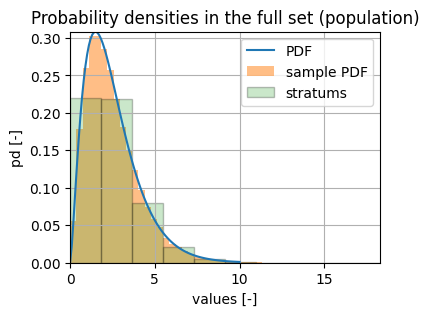

In [2]:
import numpy as np
from scipy.stats import gamma

# Generate 10,000 samples from a gamma distribution with shape parameter 2 and scale parameter 1
shape = 2.5
scale = 1
N = 100_000
x = gamma.rvs(a=shape , scale=scale, size=N)

# Plot the density of the gamma distribution
X_axis = np.linspace(0, 10, 100)  # just for the density visualization
X_density = gamma.pdf(X_axis, shape, scale=scale)

# Draw a histogram of the samples and plot it on the same graph
plt.plot(X_axis, X_density, label = 'PDF')
plt.hist(x, bins=50, density=True, alpha=0.5, label = 'sample PDF')
plt.hist(x, bins=10, density=True, alpha=0.25, edgecolor = 'k', label = 'stratums')
plt.legend()
plotlabels(plt.gca(),'Probability densities in the full set (population)','values [-]', 'pd [-]')
plt.show()

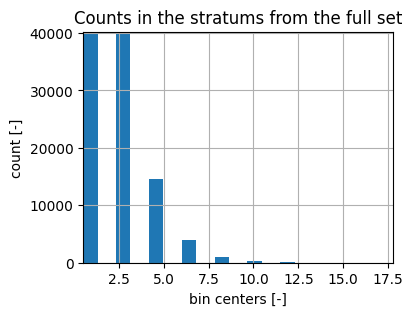

In [3]:
# Calculate stratums

# Compute the histogram of data 'x' with 10 bins.
# This function calculates the number of data points falling into each bin.
bin_counts, bin_edges = np.histogram(x, bins=10)
bin_width = bin_edges[1]-bin_edges[0]  # Calculate the width of each bin.
bin_centers = bin_edges[0:-1] + 0.5*bin_width # This will be used as the x-coordinates for the bar plot.
plt.bar(bin_centers, bin_counts) # This plot shows the distribution of data within different bins.
plotlabels(plt.gca(),'Counts in the stratums from the full set','bin centers [-]', 'count [-]')

In summary, this code takes a dataset 'x' and divides it into 10 bins (strata). It then calculates the number of data points in each bin, finds the bin widths and centers for visualization, and finally creates a bar plot to visualize the histogram with appropriate labels and a title for clarity. This is useful for understanding the distribution of data within different segments or strata.

In [4]:
# bin_counts
# bin_counts.sum()  # N

Let's say we need $n=100$ subsamples from the $N$ (full) sample.

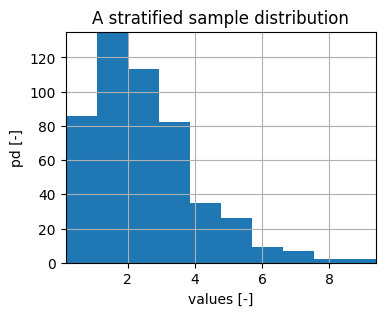

In [5]:
n = 500
# simply put we will samples according to weigths according to bin_counts randomly per bins.
weights_percent = n*bin_counts/N
weights_int = weights_percent.astype(int)

sub_samples = []
for i in range(len(bin_centers)):
    fr = bin_edges[i]
    to = bin_edges[i+1]
    w = weights_int[i]
    sub_samples_per_bin_i = np.random.choice(x[(fr <= x) & (x < to)], size = w, replace = True)
    sub_samples.append(sub_samples_per_bin_i)

samples = np.concatenate(sub_samples).flatten()  # flatten a list(!) of arrays
plt.hist(samples)
plotlabels(plt.gca(),'A stratified sample distribution','values [-]', 'pd [-]')

Now, let's say we need $n=100$ subsamples from $N$ (full) sample in total $m=10$ times, also called $m$ folds. Basically, we embrace the above cell in another loop.

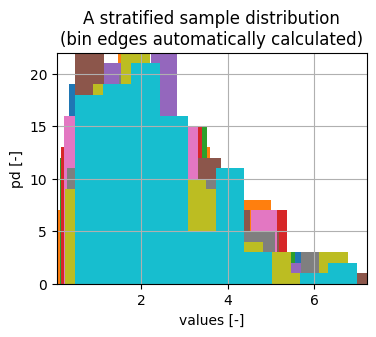

In [6]:
m = 10
m_samples = []

for k in range(m):
    # let's say we need n=100 subsamples from N (full) sample
    n = 100
    # simply put we will samples according to weigths according to bin_counts randomly per bins.
    weights_percent = n*bin_counts/N
    weights_int = weights_percent.astype(int)

    sub_samples = []
    for i in range(len(bin_centers)):
        fr = bin_edges[i]
        to = bin_edges[i+1]
        w = weights_int[i]
        sub_samples_per_bin_i = np.random.choice(x[(fr <= x) & (x < to)], size = w, replace = True)
        sub_samples.append(sub_samples_per_bin_i)

    samples = np.concatenate(sub_samples).flatten()  # flatten a list(!) of arrays
    plt.hist(samples, bins = 10)

    m_samples.append(samples)
plotlabels(plt.gca(),'A stratified sample distribution\n(bin edges automatically calculated)','values [-]', 'pd [-]')
# m_samples  # a list of arrays

Finally, we will make simple random samples for comparison, that is let's say we need $n=100$ subsamples from $N$ (full) sample in total $m=10$ times.

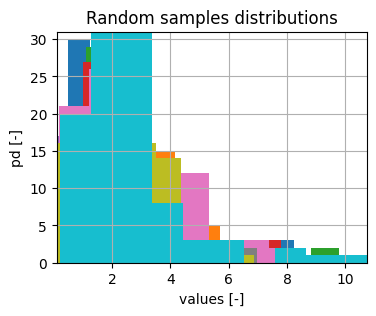

In [7]:
random_samples = []
for k in range(m):
    random_samples.append(np.random.choice(x, size = n, replace = True))

#random_samples  # a list of arrays
for k in range(len(random_samples)):
    plt.hist(random_samples[k], bins = 10)
plotlabels(plt.gca(),'Random samples distributions','values [-]', 'pd [-]')

In [8]:
# random_samples

We compare the distributions

In [9]:
# for the stratified samples:
bin_counts  # true

diffs_strat_per_bins = []
for i in range(len(bin_counts)):
    m_samples_counts, _ = np.histogram(m_samples[i], bins = bin_edges)  # If bins is a sequence, it defines a monotonically increasing array of bin edges, including the rightmost edge
    true_prop = bin_counts / N  # divide by number of samples to get a proportion
    sample_prop = m_samples_counts / n # divide by number of samples to get a proportion
    #print(true_prop)
    #print(sample_prop)
    diffs_per_bins = (true_prop - sample_prop) *100
    print(diffs_per_bins)
    diffs_strat_per_bins.append(diffs_per_bins)

# mivel minden binben mindig ugyanannyi mintát vettünk, ezért a hibák is állandóak.

[0.215 0.991 0.624 0.93  0.954 0.233 0.041 0.008 0.003 0.001]
[0.215 0.991 0.624 0.93  0.954 0.233 0.041 0.008 0.003 0.001]
[0.215 0.991 0.624 0.93  0.954 0.233 0.041 0.008 0.003 0.001]
[0.215 0.991 0.624 0.93  0.954 0.233 0.041 0.008 0.003 0.001]
[0.215 0.991 0.624 0.93  0.954 0.233 0.041 0.008 0.003 0.001]
[0.215 0.991 0.624 0.93  0.954 0.233 0.041 0.008 0.003 0.001]
[0.215 0.991 0.624 0.93  0.954 0.233 0.041 0.008 0.003 0.001]
[0.215 0.991 0.624 0.93  0.954 0.233 0.041 0.008 0.003 0.001]
[0.215 0.991 0.624 0.93  0.954 0.233 0.041 0.008 0.003 0.001]
[0.215 0.991 0.624 0.93  0.954 0.233 0.041 0.008 0.003 0.001]


Since we took the same number of samples in each bin of each fold, the error will remain the same.

In [10]:
# random_samples
bin_counts  # the true distribution.

diffs_rand_per_bins = []
for i in range(len(bin_counts)):
    random_samples_i, _ = np.histogram(random_samples[i], bins = bin_edges)  # If bins is a sequence, it defines a monotonically increasing array of bin edges, including the rightmost edge
    true_prop = bin_counts / N  # divide by number of samples to get a proportion
    sample_prop = random_samples_i / n # divide by number of samples to get a proportion
    #print(true_prop)
    #print(sample_prop)
    diffs_per_bins = (true_prop - sample_prop) *100
    print(diffs_per_bins)

    diffs_rand_per_bins.append(diffs_per_bins)

[-6.785e+00  9.910e-01  4.624e+00  2.930e+00 -2.046e+00  2.330e-01
  4.100e-02  8.000e-03  3.000e-03  1.000e-03]
[ 9.215e+00 -2.009e+00 -8.376e+00  9.300e-01 -4.600e-02  2.330e-01
  4.100e-02  8.000e-03  3.000e-03  1.000e-03]
[ 5.215e+00 -3.009e+00 -1.376e+00  9.300e-01 -1.046e+00 -7.670e-01
  4.100e-02  8.000e-03  3.000e-03  1.000e-03]
[-1.785e+00 -1.009e+00  4.624e+00 -1.070e+00 -1.046e+00  2.330e-01
  4.100e-02  8.000e-03  3.000e-03  1.000e-03]
[-1.785e+00 -1.009e+00 -3.760e-01  2.930e+00 -4.600e-02  2.330e-01
  4.100e-02  8.000e-03  3.000e-03  1.000e-03]
[ 2.215e+00 -4.009e+00 -1.376e+00  1.930e+00  9.540e-01  2.330e-01
  4.100e-02  8.000e-03  3.000e-03  1.000e-03]
[ 3.215e+00  4.991e+00 -4.376e+00 -2.070e+00 -1.046e+00 -7.670e-01
  4.100e-02  8.000e-03  3.000e-03  1.000e-03]
[ 7.2150e+00 -1.4009e+01  6.6240e+00 -1.0700e+00  9.5400e-01  2.3300e-01
  4.1000e-02  8.0000e-03  3.0000e-03  1.0000e-03]
[ 4.215e+00 -6.009e+00  2.624e+00 -7.000e-02 -1.046e+00  2.330e-01
  4.100e-02  8.000e

However in simple random sampling, the counts in different bins may vary.

Finally we make a scatterplot to visualize the errors.

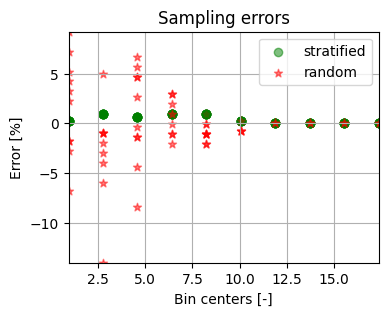

In [11]:
for i in range(len(diffs_rand_per_bins)):
    if i == 0:
        plt.scatter(bin_centers, diffs_strat_per_bins[i], color = 'green', alpha = 0.5, label = 'stratified')
        plt.scatter(bin_centers, diffs_rand_per_bins[i], color = 'red', marker = '*', alpha = 0.5, label = 'random')
    else:
        plt.scatter(bin_centers, diffs_strat_per_bins[i], color = 'green', alpha = 0.5)
        plt.scatter(bin_centers, diffs_rand_per_bins[i], color = 'red', marker = '*', alpha = 0.5)  # ugyanaz csak label nélkül

plt.legend()
plotlabels(plt.gca(), 'Sampling errors', 'Bin centers [-]', 'Error [%]')

We see, that random sampling has larger errors at different bin centers.

# Automatic approach

We us `pandas` and `StratifiedShuffleSplit` since these are common solutions and easily integratable into ML pipelines.

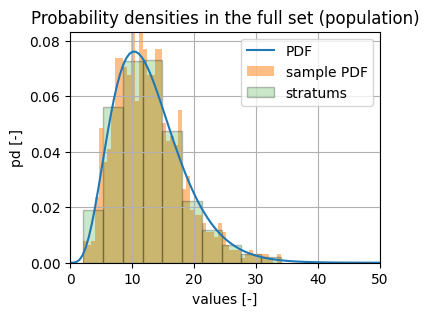

In [12]:
import numpy as np
from scipy.stats import gamma

# Generate 10,000 samples from a gamma distribution with shape parameter 2 and scale parameter 1
shape = 5.05
scale = 2.55
N = 1_000
x = gamma.rvs(a=shape , scale=scale, size=N, random_state = 0)

# Plot the density of the gamma distribution
X_axis = np.linspace(0, 50, 100)  # just for the density visualization
X_density = gamma.pdf(X_axis, shape, scale=scale)

# Draw a histogram of the samples and plot it on the same graph
plt.plot(X_axis, X_density, label = 'PDF')
plt.hist(x, bins=50, density=True, alpha=0.5, label = 'sample PDF')
plt.hist(x, bins=10, density=True, alpha=0.25, edgecolor = 'k', label = 'stratums')
plt.legend()
plotlabels(plt.gca(),'Probability densities in the full set (population)','values [-]', 'pd [-]')
plt.show()

You may split the set into training and validation set.

In [13]:
from sklearn.model_selection import train_test_split

# if you do not have target labels:
X_train, X_test = train_test_split(x, test_size=0.2, random_state=0)
# if you have target labels:
# X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=0)

len(X_train), len(X_test)

(800, 200)

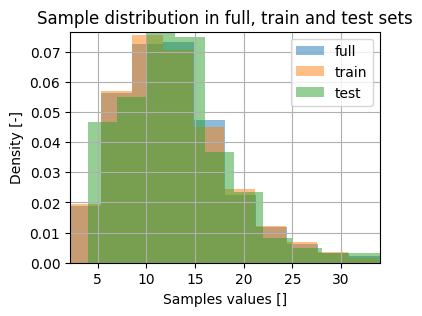

In [14]:
plt.hist(x,       bins = 10, alpha = 0.5, label='full',  density = True)
plt.hist(X_train, bins = 10, alpha = 0.5, label='train', density = True)
plt.hist(X_test,  bins = 10, alpha = 0.5, label='test',  density = True)
plt.legend()
plotlabels(plt.gca(), 'Sample distribution in full, train and test sets', 'Samples values []', 'Density [-]')

We see, that the full-, train-, and test distributions are quite close.

We will make a dataframe and use pd.cut() to make a categorical attribute in pandas. In order to have senseful bin_edges, we remain at np.histogram

In [15]:
counts, bin_edges = np.histogram(x)
print(bin_edges)
# also we need labels in the new cat feature of the df:
bin_labels = range(0,len(bin_edges)-1)

# Create a dataframe from the numpy array
import pandas as pd

df = pd.DataFrame(x, columns=['val'])

# Define categorical values
df['cat'] = pd.cut(df['val'], bins=bin_edges,  labels=bin_labels)
df

[ 2.16865123  5.35087634  8.53310146 11.71532657 14.89755168 18.07977679
 21.26200191 24.44422702 27.62645213 30.80867724 33.99090236]


,val,cat
0,24.680751,7
1,14.382489,3
2,25.618015,7
3,7.386497,1
4,11.464876,2
...,...,...
995,25.014579,7
996,11.042731,2
997,17.705058,4
998,19.233710,5


Check if we have a NaNs, and unfortunately, yes we have. What could have gone wrong?

In [16]:
df.loc[df.cat.isnull()] # check if you have a NaNs.

,val,cat
381,2.168651,NaN


In [17]:
print(bin_edges[0])
print(df.iat[381,0])
bin_edges[0] == df.iat[381,0]

2.168651231138588
2.168651231138588


True

An important trick for similart tasks is to use the `include_lowest` parameter. After setting it true, the smallest value in the variable `val` which coincides with the smallest bin edge is now included, thus no NaN value is found. Also we make a quick visual check, and the count distribution of the first sample seems fine.

In [18]:
# we used the keyword  include_lowest=True to avoid this issue
df['cat'] = pd.cut(df['val'], bins=bin_edges,  labels=bin_labels, include_lowest=True)
df.loc[df.cat.isnull()] # check if you have a NaNs.

,val,cat


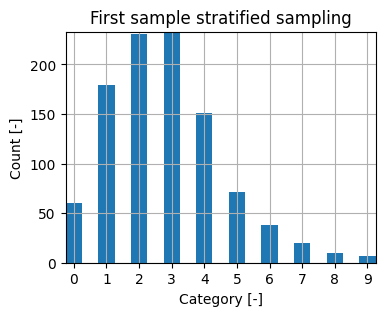

In [19]:
df.cat.value_counts().sort_index().plot.bar(rot=0, grid=True)
plotlabels(plt.gca(), 'First sample stratified sampling', "Category [-]", "Count [-]")

Now we will implement use the `StratifiedShuffleSplit` to have *stratified* and *shuffled* train and test $splits$ 10 times. A really convenient solution.

In [20]:
# 10 different stratified splits of the same dataset: (5 cat for 2 sets: test~ and train~)
from sklearn.model_selection import StratifiedShuffleSplit

splitter = StratifiedShuffleSplit(n_splits=10, test_size=0.2, random_state=0)

# if you have train and test sets
strat_splits = []
for train_index, test_index in splitter.split(df, df["cat"]):
    strat_train_set_n = df.iloc[train_index]
    strat_test_set_n = df.iloc[test_index]
    strat_splits.append([strat_train_set_n, strat_test_set_n])

# # equivalently for a single stratified split:
# strat_train_set, strat_test_set = train_test_split(df, test_size=0.2, stratify=df["Value_cat"], random_state=42)

we have 10 splits each with the same size for train and test sets.

In [21]:
strat_splits[0]
# strat_splits[1]
# strat_splits[2]
# etc...

[           val cat
 712  14.128761   3
 502   8.625713   2
 305   9.733148   2
 778  22.174687   6
 122   7.518646   1
 ..         ...  ..
 541  16.270639   4
 291  24.490013   7
 399   9.634884   2
 979   9.573163   2
 675   6.758082   1
 
 [800 rows x 2 columns],
            val cat
 213   6.799636   1
 163  20.058998   5
 366  10.089111   2
 561  13.335196   3
 468  13.836076   3
 ..         ...  ..
 724   6.526253   1
 584   9.004812   2
 325   8.730621   2
 549   7.545262   1
 915  11.038281   2
 
 [200 rows x 2 columns]]

In [22]:
# For now, we just use the first split:
strat_train_set, strat_test_set = strat_splits[0]

we will plot the count distribution of all train and test sets

Text(0.5, 1.0, 'Sample distibutions after stratified sampling')

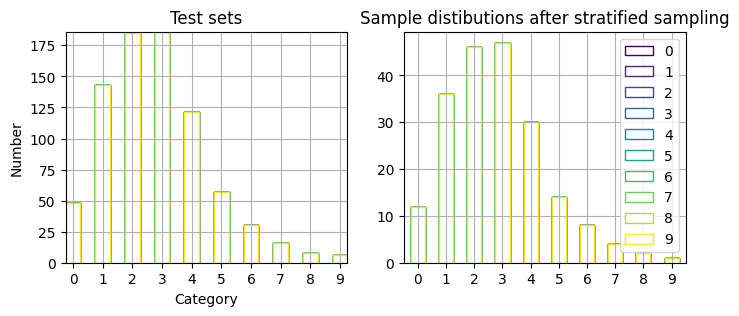

In [23]:
colors = plt.cm.viridis(np.linspace(0, 1, len(strat_splits)))

fig, ax = plt.subplots(1,2, figsize = (8,3))

for i in range(len(strat_splits)):
    strat_train_set, strat_test_set = strat_splits[i]

    strat_train_set.cat.value_counts().sort_index().plot.bar(ax = ax[0], rot=0, grid=True, color = 'white', edgecolor=colors[i], label = str(i))
    strat_test_set.cat.value_counts().sort_index().plot.bar(ax = ax[1], rot=0, grid=True, color = 'white', edgecolor=colors[i], label = str(i))

plt.legend()
plotlabels(ax[0], 'Train sets', "Category", "Number")
plotlabels(ax[0], 'Test sets', "Category", "Number")
plt.title('Sample distibutions after stratified sampling')

We introduce again a simple random sampling for comparison. Also we will leave the stratified test sets out of consideration.

In [24]:
# compare random and stratified sampling methods and witness, how stratified sampling is better to avoid sampling bias
def cat_proportions(data):
    return data["cat"].value_counts() / len(data)

# random sampling:
train_set, test_set = train_test_split(df, test_size=0.2, random_state=0)

# strat. sampling:
strat_train_sets, strat_test_sets = train_test_split(df, test_size=0.2, stratify=df["cat"], random_state=0)

# we drop here the test sets
compare_props = pd.DataFrame({
    "Overall[%]": cat_proportions(df),
    "Random[%]": cat_proportions(test_set),
    "Stratified[%]": cat_proportions(strat_train_sets)
}).sort_index()

compare_props.index.name = "Income Category"
compare_props["Rand.Error[%]"] = (compare_props["Random[%]"] / compare_props["Overall[%]"] - 1)
compare_props["Strat.Error[%]"] = (compare_props["Stratified[%]"] / compare_props["Overall[%]"] - 1)

(compare_props * 100).round(2)

,Overall[%],Random[%],Stratified[%],Rand.Error[%],Strat.Error[%]
Income Category,,,,,
0,6.0,4.5,6.00,-25.00,0.00
1,17.9,16.0,17.88,-10.61,-0.14
2,23.1,20.5,23.12,-11.26,0.11
3,23.3,27.0,23.25,15.88,-0.21
4,15.1,17.0,15.12,12.58,0.17
5,7.1,8.0,7.12,12.68,0.35
6,3.8,3.0,3.75,-21.05,-1.32
7,2.0,2.0,2.00,0.00,0.00
8,1.0,0.5,1.00,-50.00,0.00
